# Local Binary Pattern encoding for ecocup images

In [1]:
from skimage.feature import local_binary_pattern
import numpy as np

In [2]:
def lbp_histogram(image):
    # separate image in 6 blocks
    blocks = np.array_split(image, 3)
    new_blocks = []
    for block in blocks:
        new_blocks += np.array_split(block, 2, axis=1)
    blocks = np.array(blocks)

    # calculate LBP for each block
    lbp_blocks = []
    for block in blocks:
        lbp_blocks.append(local_binary_pattern(block, 5, 1))

    # calculate histogram for each block
    hist_blocks = []
    for block in lbp_blocks:
        hist_blocks.append(np.histogram(block, bins=10, range=(0, 10))[0])

    # concatenate histograms
    hist = np.concatenate(hist_blocks)
    return hist

In [3]:
# load images
import os
from skimage import io
from skimage.color import rgb2gray

pos_path = "data/augmented_images"
neg_path = "data/negative_images"

pos_images = []
neg_images = []

for filename in os.listdir(pos_path):
    if filename.endswith(".jpg"):
        pos_images.append(rgb2gray(io.imread(os.path.join(pos_path, filename)))[1:-1])

for filename in os.listdir(neg_path):
    if filename.endswith(".jpg"):
        neg_images.append(rgb2gray(io.imread(os.path.join(neg_path, filename)))[1:-1])

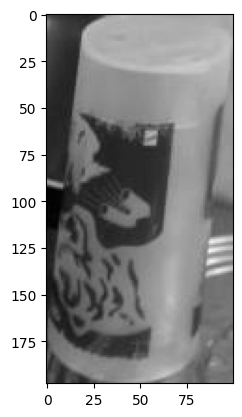

In [4]:
from matplotlib import pyplot as plt

plt.imshow(pos_images[0], cmap="gray")

In [5]:
from tqdm.notebook import tqdm

encoded_images = [lbp_histogram(image) for image in tqdm(pos_images+neg_images)]

  0%|          | 0/1439 [00:00<?, ?it/s]

/Users/pierreadorni/Documents/ecocup_detection/venv/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(encoded_images, [1]*len(pos_images)+[0]*len(neg_images), test_size=0.2, random_state=42)

In [25]:
# RF classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=95, max_depth=23, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.875


In [36]:
# RF classifier using cross validation
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=95, max_depth=23, random_state=42)
scores = cross_val_score(rf, encoded_images, [1]*len(pos_images)+[0]*len(neg_images), cv=5)
print(np.mean(scores))

0.8637896825396825


In [8]:
# SVM classifier
from sklearn.svm import SVC

svm = SVC(kernel="linear", random_state=42, verbose=1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(accuracy_score(y_test, y_pred))

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
# gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8194444444444444


In [10]:
# MLP classifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8402777777777778


In [11]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8055555555555556


In [12]:
# AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8680555555555556


In [26]:
# Adaboost has good results, perform grid search to find best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(ada, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'learning_rate': 1.0, 'n_estimators': 100}

In [30]:
def fit_grid_search(modelClass, X_train, y_train, param_grid):
    model = modelClass()
    grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    opt_model = modelClass(**grid_search.best_params_)
    opt_model.fit(X_train, y_train)
    return opt_model

In [37]:
# RF had good results, perform grid search to find best parameters

param_grid = {
    'n_estimators': [85, 90, 95],
    'max_depth': [23, 24, 25]
}

rf = fit_grid_search(RandomForestClassifier, encoded_images, [1]*len(pos_images)+[0]*len(neg_images), param_grid)
# get cv accuracy
scores = cross_val_score(rf, encoded_images, [1]*len(pos_images)+[0]*len(neg_images), cv=5)
print(np.mean(scores))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8679442508710802
